# Estrategias Evolutivas

La librería **Pyristic** incluye una clase llamada *EvolutionStrategy*  inspirada en la metaheurística de *Estrategias evolutivas* (EE) para resolver problemas de minimización. Para trabajar con esta clase se requiere hacer lo siguiente:

1. Definir:
    * La función objetivo $f$.
    * La lista de restricciones.
    * Lista de límites inferiores y superiores.
    * Configuración de operadores de la metaheurística (opcional).
    
2. Crear una clase que hereda de *EvolutionStrategy*.

3. Sobreescritura de funciones auxiliares:
    
    * initialize_step_weights (opcional)
    * initialize_population (opcional)
    * fixer (opcional)
    * mutation_operator (opcional)
    * crossover_operator (opcional)
    * adaptive_crossover (opcional)
    * adaptive_mutation (opcional)
    * survivor_selection (opcional)

A continuación se mostrarán los elementos que se deben importar. 

In [1]:
import sys
import os

#library_path is the path where the Optimpy library is located.
library_path = "/home/dell/Documentos/Git_proejcts/optimizacion-con-metaheuristicas/"
#library_path = "/Users/adrianamenchacamendez/Documentos/enes_morelia/papime/optimizacion-con-metaheuristicas/"
sys.path.append(os.path.abspath(library_path))



In [2]:
from pprint import pprint
import math
import numpy as np 
import copy
from IPython.display import Image
from IPython.core.display import HTML 

In [3]:
from optimpy.heuristic.EvolutionStrategy_search import EvolutionStrategy
from optimpy.utils.operators import selection, mutation, crossover 
from optimpy.utils.test_function import beale_, ackley_
from optimpy.utils.helpers import EvolutionStrategyConfig,get_stats


Para ejemplificar el uso de la clase *EvolutionStrategy*,  resolveremos dos problemas de optimización continua. Estos problemas se encuentran implementados en **utils.helpers.test_function**. 


## Función de Beale
\begin{equation}
  \label{eq:BF}
  \begin{array}{rll}
  \text{minimizar:} & f(x_1, x_2) = (1.5 - x_1 + x_1x_2)^2 + (2.25 - x_1 + x_1x_2^2)^2 + (2.625 - x_1 + x_1x_2^3)^2
  &  \\
  \text{Tal que: } & -4.5 \leq x_1,x_2 \leq 4.5 &  
  \end{array}
\end{equation}

El mínimo global se encuentra en $x^* = (3, 0.5)$ y $f(x^*) = 0$. 


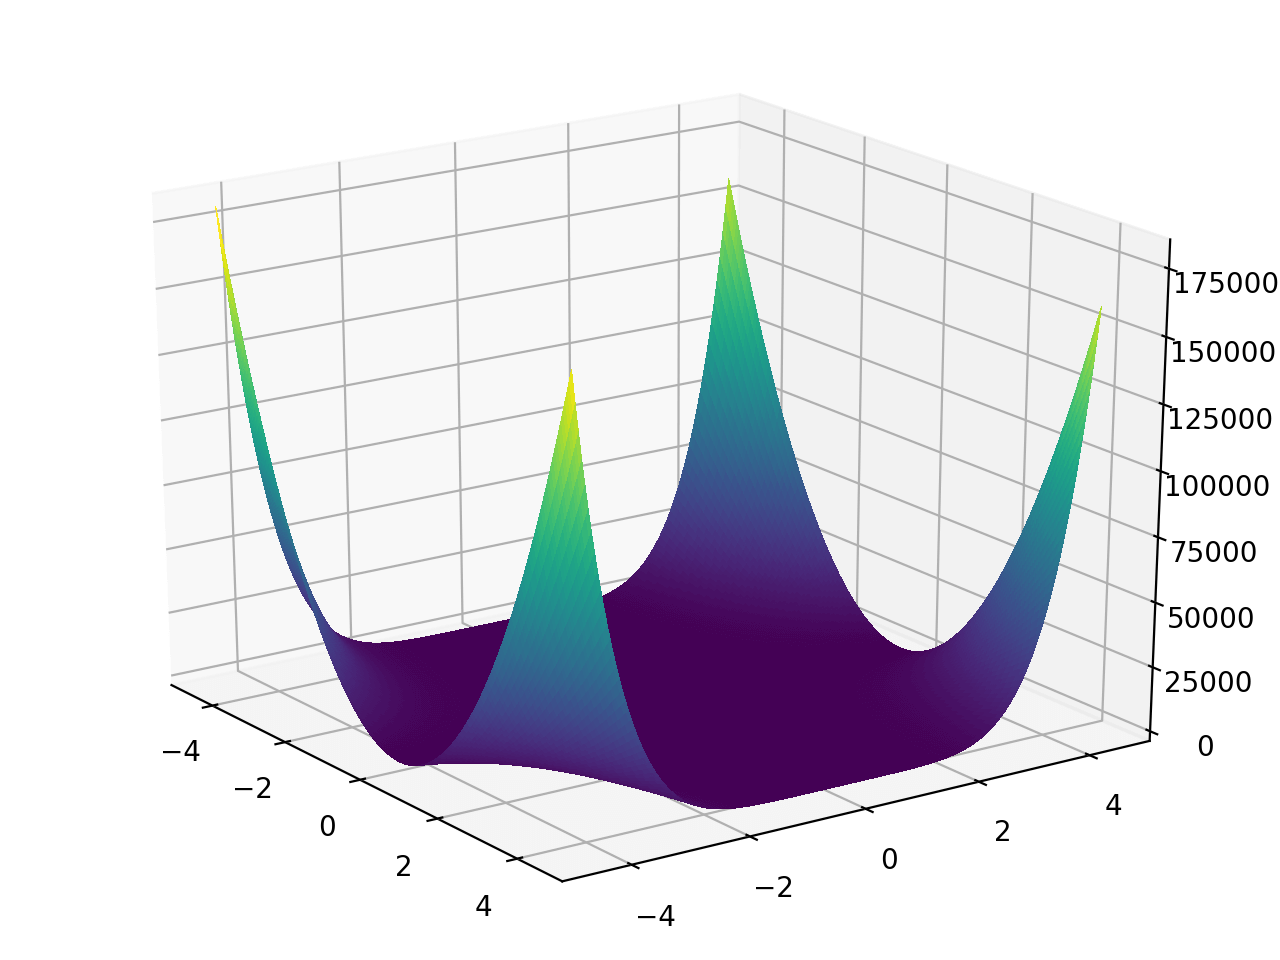

In [4]:
Image(filename="include/beale.png", width=500, height=300)

In [5]:
beale_

{'function': CPUDispatcher(<function beale_function at 0x7fc8c4126378>),
 'constraints': [CPUDispatcher(<function constraint1_beale at 0x7fc8cc408510>)],
 'bounds': [-4.5, 4.5],
 'decision_variables': 2}

### Clase EvolutionStrategy
Para hacer uso de la metaheurística EE implementada en la librería de **Pyristic** se puede hacer lo siguiente.

* Crear un objeto de tipo *EvolutionStrategy* y mandar a llamar a su método *optimize*. En este caso se utilizan los operadores y parámetros por defecto.
* Crear una clase que herede de la clase *EvolutionStrategy* y sobreescribir los métodos.
* Declarar un objeto del tipo *EvolutionStrategyConfig* (ubicado en *utils.helpers*) y ajustar los operadores.
* Realizar una combinación de las dos antes mencionadas.

#### Métodos
Los métodos que contiene la clase EvolutionStrategy son: 


* **fixer**. Si la solución no está dentro de los límites (restricciones de caja), actualiza el valor de la variable con el valor del límite que rebasó. De lo contrario, regresa la misma solución.

 Argumentos:
  * **ind**. Índice del individuo.
 
 Valor de retorno:
  * Un arreglo de *numpy* representado a la solución que reemplazará la solución infactible.

* **initialize_population**. Crea una población de individuos aleatorios. Para ello se generan números aleatorios, utilizando una distribución uniforme, dentro de los límites indicados para cada variable. Los individuos generados son almacenados en logger con la llave de `parent_population_x`. Esta función es llamada dentro de la función *optimize*.

 Valor de retorno:
   * Un arreglo bidimensional de *numpy*. El número de filas es igual al tamaño de la población y el número de columnas es igual al número de variables que tiene el problema que se está resolviendo.

* **initialize_step_weights.** Inicializa el tamaño de desplazamiento de cada una de las variables de decisión pertenecientes a cada individuo de la población. Para ello se generan números aleatorio en el intervalo $[0,1]$, utilizando una distribución uniforme. Los tamaños de desplazamiento están almacenados en logger con la llave `parent_population_sigma`.

    Valor de retorno:
     * Un arreglo bidimensional de numpy. El número de filas es igual al tamaño de la población y el número de columnas es igual al número de variables que tiene el problema que se está resolviendo. Cada variable tiene su propio tamaño de paso.



* **mutation_operator**, Muta las variables de decisión, las cuales se encuentran almacenadas en el diccionario logger con la llave `parent_population_x`. La mutación se realiza de la siguiente forma:

    \begin{equation}
      \label{eq:mutarVariables}
      x'_i = x_i + \sigma'_i \cdot N(0, 1)
    \end{equation}

  donde $x'_j$ es la variable mutada, $x_j$ la variable a mutar, $\sigma'_j$ el tamaño de paso (previamente mutado) y N(0,1) devuelve un número aleatorio usando una distribución normal con media $0$ y desviación estándar igual con $1$.

  Es importante tener en cuenta que la fila $j$ de `parent_population_x` debe corresponder con la fila $j$ de `parent_population_sigma`.

  Valor de retorno:
   * Un arreglo bidimensional de numpy representado a los nuevos individuos.





* **adaptive_mutation.**  Muta los tamaños de paso, los cuales se encuentran almacenados en el diccionario logger con la llave `offspring_population_sigma`. Actualmente, la librería **Pyristic** cuenta con dos métodos para la actualización de los tamaños de paso, los métodos se encuentran en *utils.operators.mutation*. 
  
  Los métodos de mutación para sigma son: 
   * *sigma_mult_adaptive_mutator.* Crea una variable de desplazamiento por cada variable de decisión de cada individuo.
   * *sigma_single_adaptive_mutator.* Crea una sola variable de desplazamiento por cada individuo de la población.
  
 Por defecto la metaheurística utiliza *sigma_mult_adaptive_mutator*, la forma en que opera es:
    \begin{equation*}
      \label{eq:mutarNSigmas}
      \sigma'_i = \sigma_i \cdot e ^ {\tau' \cdot N(0,1) + \tau \cdot N_i(0,1)}
    \end{equation*}


* **crossover_operator.** Genera la población de nuevos individuos trás la cruza de cada dos inviduos de la población en dicha generación. Estos nuevos individuos son almacenandos en logger con la llave `offspring_population_x`.
    
    Argumentos:
     * **parent_ind1.** Indices de los individuos que son seleccionados para emplear el operador de cruza.
     * **parent_ind2.** Indices de los individuos que son seleccionados para emplear el operador de cruza.
    
 Valor de retorno:
     * Un arreglo bidimensional de *numpy* representado a los nuevos individuos.
  
  Los inviduos de *parent_ind1* y *parent_ind2* son emparejados, es decir, se toman los padres en la posición $i$ en los dos arreglos y dichos padres son cruzados.

  Por defecto la metaheurística utiliza el operador de cruza discreta que se encuentra en *utils.operators.crossover* con el nombre de *discrete*.
  

* **adaptive_crossover.** Genera una cruza de los tamaños de paso de los individuos seleccionados de la población. Estos nuevos tamaños de paso son almacenados en logger con la llave `offspring_population_sigma`.

 Argumentos:
 * **parent_ind1.** Indices de los individuos que son seleccionados para emplear el operador de cruza.
 * **parent_ind2.** Indices de los individuos que son seleccionados para emplear el operador de cruza.
 
 Valor de retorno:
 * Un arreglo bidimensional de *numpy* representando los nuevos tamaños de paso.
 
  Por defecto la metaheurística utiliza el operador que se encuentra en *utils.operators.crossover* con el nombre de *intermediate*.

* **survivor_selection.** Selección de los individuos que pasarán a la próxima generación. la librería cuenta con dos esquemas de selección implementados en *utils.operators.selection*. Los esquemas de selección son:
    * **merge_selector.** Esquema $(\mu + \lambda)$, selecciona $\mu$ individuos que son obtenidos al unir la población de individuos creados por la cruza y la población actual. Los  individuos que permanecerán para la próxima generación son los más *aptos* de acuerdo a su función objetivo.
    * **replacement_selector.** El esquema $(\mu, \lambda)$, reemplaza la población actual con $\mu$ individuos de la población obtenida por la cruza. Los nuevos individuos son seleccionados por su función objetivo.
  
  Valor de retorno:
    * Una lista con un arreglo bidimensional de *numpy* representando la población $\mu$ y un arreglo *numpy* que será los valores de la función objetivo correspondientes de los individuos de la población $\mu$.
    
  Por defecto la metaheurística utiliza el esquema $(\mu + \lambda)$.

## Ejecución de la metaheurística
Creamos una instancia del tipo EvolutionStrategy indicando en los parámetros la función objetivo, las restricciones del problema, los limites del espacio de búsqueda por cada una de las variables de decisión y el número de variables de decisión.


In [6]:
Beale = EvolutionStrategy(**beale_)

Finalmente, se llama a la función optimize (esta función es la misma para todas las clases en la librería). La función optimize recibe los siguientes parámetros:
   * **generations.**  Número de generaciones (iteraciones de la metaheurística).
   * **population_size.** Tamaño de la población (número de individuos).
   * **offspring_size.** Tamaño de la población creada por la cruza.
   * **eps_sigma.** Número flotante, indica lo menos que puede ser por tamaño de paso, por defecto está en 0.001.
   * **verbose.**  Muestra en que iteración se encuentra nuestra búsqueda, por defecto está en True.
   * **kargs: diccionario con parámetros adicionales que queremos incluir en la búsqueda.
    
Para esta ejecución para la función de Beale utilizaremos los siguientes parámetros:

   * **generations** = $300$
   * **population_size** = 80 
   * **offspring_size** = 160



### ($\mu + \lambda$) - EE
Por defecto, la metaheurística realiza:
* La selección de sobrevivientes, utiliza un esquema $(\mu + \lambda)$
* El operador de cruza  para las variables de decisión es *recombinación discreta*.
* El operador de cruza para los tamaños de paso es *recombinación intermedia*.


In [7]:
Beale.optimize(3,3,6,verbose=True)

100%|██████████| 3/3 [00:01<00:00,  1.70it/s]


In [8]:
print(Beale)

Evolution Strategy search: 
 f(X) = 0.10955969930560476 
 X = [4.5        0.70923685] 
 Constraints: 
 x1: -4.5 <= 4.50 <= 4.5 
 x2: -4.5 <= 0.71 <= 4.5 



In [9]:
Beale.logger

{'individual': array([4.5       , 0.70923685]),
 'aptitude': 0.10955969930560476,
 'current_iter': 3,
 'total_iter': 3,
 'parent_population_size': 3,
 'offspring_population_size': 6,
 'parent_population_x': array([[4.43682245, 0.72605756],
        [4.5       , 0.70923685],
        [4.5       , 0.57322008]]),
 'parent_population_sigma': array([[0.96320332, 0.79743888],
        [0.55124707, 0.10170293],
        [0.31733607, 0.2256847 ]]),
 'parent_population_fitness': array([0.11702278, 0.1095597 , 1.82747003]),
 'offspring_population_x': array([[ 4.5       ,  1.35359872],
        [ 4.5       ,  1.21361455],
        [ 4.11595181,  0.89252655],
        [ 4.5       , -0.03443388],
        [ 4.5       ,  1.1938241 ],
        [ 4.5       ,  0.70923685]]),
 'offspring_population_sigma': array([[0.50910975, 0.31770413],
        [0.33123912, 0.40375854],
        [0.80659252, 0.1149148 ],
        [0.53433695, 0.85470618],
        [0.64947934, 0.21094289],
        [0.55124707, 0.10170293]]),
 'of

Para revisar el comportamiento de la metaheurística en determinado problema, la librería **Pyristic** cuenta con una función llamada get_stats. Esta función se encuentra en utils.helpers y recibe como parámetros:

   * Objeto que realiza la búsqueda de soluciones.
   * El número de veces que se quiere ejecutar la metaheurística.
   * Los argumentos que recibe la función optimize (debe ser una tupla).
   * Argumentos adicionales a la búsqueda(opcional).

La función **get_stats** retorna un diccionario con algunas estadísticas de las ejecuciones.



In [10]:
args = (200, 100, 150)
statistics = get_stats(Beale, 30, args)

100%|██████████| 200/200 [00:00<00:00, 1012.96it/s]


In [11]:
pprint(statistics)

{'Best solution': {'f': 2.531750467693685e-29, 'x': array([3. , 0.5])},
 'Mean': 7.167292303379842e-23,
 'Standard deviation': 2.7240425061399494e-22,
 'Worst solution': {'f': 1.5028900595968608e-21, 'x': array([3. , 0.5])}}


### (1+1) - EE
Para este ejemplo resolveremos este problema utilizando la versión más simple de un algoritmo de estrategias evolutivas.

La búsqueda local se desarrolla de la siguiente manera:
 1. Mutamos el individuo con un parámetro ($\sigma$) de adaptación independiente al número de variables de decisión que tenga el problema.
 2. Mutamos $\sigma$ del nuevo individuo utilizando la regla del éxito 1/5.
 3. Se selecciona el individuo más apto que pasará a la próxima generación, es decir, se seleccionará al individuo que tenga un valor más pequeño en la función objetivo.

La regla del éxito 1/5, actualiza el parámetro de la siguiente manera:
\begin{equation}
  \sigma = 
  \begin{cases}
   \sigma / c & \text{Si } p_s > 1/5, \\
   \sigma \cdot c & \text{Si } p_s < 1/5, \\
   \sigma  & \text{Si } p_s = 1/5 \\
  \end{cases}
\end{equation}

La forma en que mutamos el nuevo individuo se realiza así:
    \begin{equation}
      \label{eq:mutarVariables}
      x'_i = x_i + \sigma'_i \cdot N(0, 1)
    \end{equation}

Es importante resaltar, que esta versión no considera el operador de cruza (*crossover_operator* y *adaptive_crossover*). La razón es porque el operador está condicionado a seleccionar dos individuos de la población para generar 2 nuevas soluciones. 

Vamos a sobreescribir *crossover_operator* y *adaptive_crossover* para que retornen el individuo original sin cambio alguno. Las funciones que serán alteradas en su comportamiento son:
* adaptive_mutation, se encarga de modificar $\sigma$.
* mutation_operator, esta función hará un pequeño cambio a la solución original tomando $\sigma$.
* initializing_step_weights, Inicializar el conjunto de $\sigma$.

In [12]:
beale_

{'function': CPUDispatcher(<function beale_function at 0x7fc8c4126378>),
 'constraints': [CPUDispatcher(<function constraint1_beale at 0x7fc8cc408510>)],
 'bounds': [-4.5, 4.5],
 'decision_variables': 2}

In [13]:
class ESBasic(EvolutionStrategy):
      
    def __init__(self, function  ,\
                 decision_variables:int,\
                 constraints: list,\
                 bounds: np.ndarray):
        super().__init__(function, decision_variables, constraints, bounds)
        
        self.successful = 0

    
    def crossover_operator(self, parent_ind1,\
                                 parent_ind2,\
                                 **kargs):
        return self.logger['parent_population_x']
    
    def adaptive_crossover(self, parent_ind1,\
                                 parent_ind2,\
                                 **kargs):
        return self.logger['parent_population_sigma']
    
    def adaptive_mutation(self, **kargs):
        
            if self.logger['current_iter'] % kargs['k'] != 0:
                return self.logger['offspring_population_sigma']
            
            ps = self.successful / kargs['k']
            self.successful = 0
            if( ps > 1/5):
                return self.logger['offspring_population_sigma']/kargs['c']
            elif( ps < 1/5):
                return self.logger['offspring_population_sigma']*kargs['c']
            else:
                return self.logger['offspring_population_sigma']
            
    def mutation_operator(self, **kargs):
        X_mutated = copy.deepcopy(self.logger['offspring_population_x'])
        X_mutated += self.logger['offspring_population_sigma'] * np.random.normal(0,1, size=X_mutated.shape) 

        if(self.f(self.logger['offspring_population_x'][0]) > self.f(X_mutated[0])):
            self.successful+=1
        
        return X_mutated
    
    def initializing_step_weights(self, eps_sigma:int, **kwargs) -> np.ndarray:
        return np.random.uniform(0,1, size=(self.logger['parent_population_size'], 1))

In [14]:
Beale_basic = ESBasic(**beale_)

En la implementación notamos que estamos haciendo uso de un argumento declarado *kargs*, dicho argumento es un diccionario que contiene información adicional a la búsqueda. En este caso contiene dos constantes que podemos modificar antes de llamar la función **EEClass.optimize**.

El diccionario tiene que ser incluido siempre con `**` antes del nombre de la variable que contiene este diccionario.

In [15]:
additional_arguments = {'k':10,'c':0.83}

In [16]:
Beale_basic.optimize(generations=100,\
                     population_size=1,\
                     offspring_size=1,\
                     **additional_arguments)

100%|██████████| 100/100 [00:00<00:00, 3951.26it/s]


In [17]:
print(Beale_basic)

Evolution Strategy search: 
 f(X) = 0.8617989584848492 
 X = [-3.48781252  1.22350314] 
 Constraints: 
 x1: -4.5 <= -3.49 <= 4.5 
 x2: -4.5 <= 1.22 <= 4.5 



In [18]:
args = (500, 1, 1, True)
statistics = get_stats(Beale_basic, 30, args,**additional_arguments )

100%|██████████| 500/500 [00:00<00:00, 14785.96it/s]


In [19]:
pprint(statistics)

{'Best solution': {'f': 6.046204079720323e-07,
                   'x': array([2.99808282, 0.49949865])},
 'Mean': 0.2718825230311985,
 'Standard deviation': 0.37798082885593254,
 'Worst solution': {'f': 0.921247769181009,
                    'x': array([-3.27730716,  1.22975648])}}


## Función de Ackley

\begin{equation}
  \min f(\vec{x}) = -20\exp \left( -0.2 \sqrt{\frac{1}{n} \sum_{i=1}^n x_i^2} \right) 
  - exp \left( \frac{1}{n} \sum_{i=1}^n \cos (2\pi x_i) \right)
  + 20 + e  
\end{equation}

El mínimo global está en $x^* = 0 $ y $f(\vec{x}) = 0$.

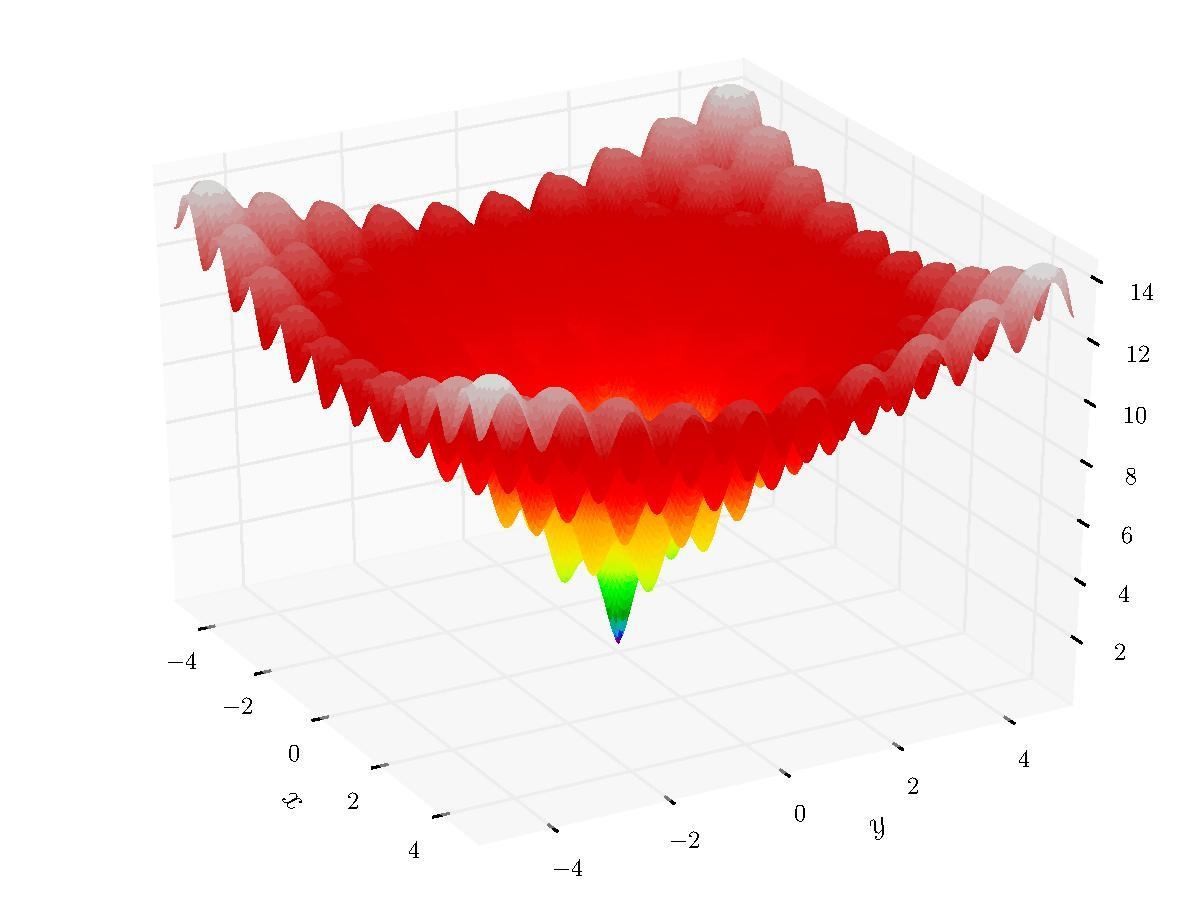

In [20]:
Image(filename="include/ackley.jpg", width=500, height=300)

In [21]:
ackley_['decision_variables']=4

### Descripción 
Ahora vamos a mostrar la forma de implementar una instancia de *EvolutionStrategy*, pero utilizando un constructor con los operadores que deseamos utilizar. A continuación explicaremos los siguientes operadores populares en el uso de estrategias evolutivas.

Operadores de cruza:
   * discrete_crossover.
   * intermediate_crossover.
 
Operadores de mutación:
   * sigma_single_adaptive.
   * sigma_mult_adaptive.
   


#### discrete_crossover 
toma como parámetros de entrada:
* Una matriz $X$ de numpy, donde, cada fila es un individuo de nuestra población y el número de columnas es el número de variables de decisión.
* Indices seleccionados como primer padre.
* Indices seleccionados como segundo padre.

Combina dos individuos de la siguiente manera:
\begin{equation}
  z_{i} = 
  \begin{cases}
   x_{i} & \text{Si } b_{i} = 1, \\
   y_{i}  & \text{Si } b_{i} = 0 \\
  \end{cases}
\end{equation}

#### intermediate_crossover
toma como parámetros de entrada:
* Una matrix $X$ de numpy, donde, cada fila es un individuo de nuestra población y el número de columnas es el número de variables de decisión.
* Un arreglo con los indices seleccionados como primer padre.
* Un arreglo con los indices seleccionados como segundo padre.
Combina dos individuos de la siguiente manera:
\begin{equation}
z_{i} = \frac{x_{i} + y_{i}}{2}
\end{equation}

#### sigma_single_adaptive
toma como parámetros de entrada:
* Una matriz $X$ de numpy, donde, cada fila es un individuo de nuestra población y el número de columnas es el número de variables de decisión.
* Un valor real que será $\tau$.

\begin{equation}
 \sigma' = \sigma \cdot e^{\tau \cdot N(0,1)}
\end{equation}

####  sigma_mult_adaptive
toma como parámetros de entrada:
* Una matriz $X$ de numpy, donde, cada fila es un individuo de nuestra población y el número de columnas es el número de variables de decisión.
* Valor numérico real $\tau'$.
* Valor numérico real $\tau$.


\begin{equation}
\sigma'_i = \sigma_i \cdot e ^ {\tau' \cdot N(0,1) + \tau \cdot N_i(0,1)}
\end{equation}

### Instancia de Programación Evolutiva¶

Para esta ejecución para la función de Ackley utilizaremos los siguientes parámetros:

   * **generations** = $250$
   * **population_size** = $100$
   * **offspring_size** = $200$
   


### ($\mu+\lambda$)-EE


En este caso dejaremos todos los demás operadores por defecto, hemos modificado son el de cruza y mutación.

In [22]:
Ackley = EvolutionStrategy(**ackley_)

In [23]:
Ackley.optimize(1,3,6)

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


In [24]:
print(Ackley)

Evolution Strategy search: 
 f(X) = 19.476948083887855 
 X = [ 8.96934925  5.09846682 18.70513223 -7.57257029] 
 Constraints: 
 x1: -30 <= 8.97 <= 30 
 x2: -30 <= 5.10 <= 30 
 x3: -30 <= 18.71 <= 30 
 x4: -30 <= -7.57 <= 30 
  



In [25]:
Ackley.logger

{'individual': array([ 8.96934925,  5.09846682, 18.70513223, -7.57257029]),
 'aptitude': 19.476948083887855,
 'current_iter': 1,
 'total_iter': 1,
 'parent_population_size': 3,
 'offspring_population_size': 6,
 'parent_population_x': array([[  8.96934925,   5.09846682,  18.70513223,  -7.57257029],
        [  8.4524102 ,   5.16316816,  18.06077986,  -7.53892779],
        [ -8.32637279,   4.07977034,  12.55491146, -28.1268455 ]]),
 'parent_population_sigma': array([[0.25164569, 0.32910243, 0.58914509, 0.0989071 ],
        [0.08987467, 0.20818987, 0.71298766, 0.13315103],
        [0.27459672, 0.02898391, 0.20343108, 0.47435981]]),
 'parent_population_fitness': array([19.47694808, 19.60054368, 20.87230857]),
 'offspring_population_x': array([[ 27.52446073,  -2.36850241,  18.36566998,  20.48893139],
        [ -8.09403774,   4.03167562,  12.49984059, -29.34127793],
        [ 27.4183298 ,  -1.81467959,  18.78930545,  21.81177869],
        [ 27.43274955,   3.95385922,  12.73259207, -28.8750776

In [26]:
Ackley.survivor_selection()

{'fitness': array([19.47694808, 19.47694808, 19.60054368]),
 'population': array([[ 8.96934925,  5.09846682, 18.70513223, -7.57257029],
        [ 8.96934925,  5.09846682, 18.70513223, -7.57257029],
        [ 8.4524102 ,  5.16316816, 18.06077986, -7.53892779]]),
 'sigma': array([[0.25164569, 0.32910243, 0.58914509, 0.0989071 ],
        [0.25164569, 0.32910243, 0.58914509, 0.0989071 ],
        [0.08987467, 0.20818987, 0.71298766, 0.13315103]])}

In [27]:
Ackley.logger['parent_population_sigma'][0]

array([0.25164569, 0.32910243, 0.58914509, 0.0989071 ])

In [28]:
args = (250, 100, 200)
statistics = get_stats(Ackley, 30, args)

100%|██████████| 250/250 [00:00<00:00, 298.67it/s]


In [29]:
pprint(statistics)

{'Best solution': {'f': 3.9968028886505635e-15,
                   'x': array([-2.08159927e-15, -1.46190110e-16,  3.20354101e-16, -4.42506442e-16])},
 'Mean': 2.1743495892678765e-12,
 'Standard deviation': 7.788381322703422e-12,
 'Worst solution': {'f': 4.224931515750541e-11,
                    'x': array([2.33953833e-12, 8.14628091e-12, 1.92327519e-11, 2.12383507e-12])}}


### ($\mu,\lambda$)-EE

El constructor de la configuración de los operadores de estrategias evolutivas (EvolutionStrategyConfig) es indicando los operadores a modificar:
* .cross( *operador de cruza* )
* .mutate( *operador de mutación* )
* .survivor_selection( *esquema de selección* )
* .fixer_invalide_solutions( *función para retornar un individuo invalido*)
* .adaptive_crossover( *operador de cruza para $\sigma$* )
* .adaptive_mutation( *operador de mutación para $\sigma$*)

In [30]:
configuration_ackley = (EvolutionStrategyConfig()
                       .survivor_selection(selection.replacement_selector())
                       )

In [31]:
print(configuration_ackley)

--------------------------------
	Configuration
--------------------------------
Survivor selection: Replacement population

--------------------------------


In [32]:
solver_ackley_custom = EvolutionStrategy(**ackley_,config=configuration_ackley)

In [33]:
solver_ackley_custom.optimize(150,100,200)

100%|██████████| 150/150 [00:00<00:00, 244.74it/s]


In [34]:
solver_ackley_custom.logger

{'individual': array([-1.26118584e-04, -1.26475657e-04, -1.29772722e-04, -2.90680402e-06]),
 'aptitude': 0.0004422434596915714,
 'current_iter': 150,
 'total_iter': 150,
 'parent_population_size': 100,
 'offspring_population_size': 200,
 'parent_population_x': array([[ 9.40205246e-05, -1.75234549e-05, -3.72942300e-04,
         -2.45349233e-04],
        [ 2.36137728e-04,  1.69480306e-04, -2.40383318e-04,
          1.94924215e-04],
        [-2.39599319e-04, -8.56343494e-05, -3.21039629e-04,
         -2.18728297e-04],
        [ 3.80038972e-04,  1.78766479e-04, -1.08703736e-04,
         -4.19441405e-05],
        [-2.90489854e-04, -1.28465891e-04, -3.70762526e-04,
         -1.00096971e-04],
        [ 2.45381266e-04, -9.59688727e-05, -2.76540561e-04,
         -2.10936988e-04],
        [ 1.15720021e-04, -3.42010671e-04, -3.25310941e-05,
          8.02426530e-05],
        [-1.96285549e-04,  1.38530838e-04,  3.84576076e-04,
          8.97181931e-05],
        [-2.02078030e-05,  3.93762321e-04,  

In [35]:
print(solver_ackley_custom)

Evolution Strategy search: 
 f(X) = 0.0004422434596915714 
 X = [-1.26118584e-04 -1.26475657e-04 -1.29772722e-04 -2.90680402e-06] 
 Constraints: 
 x1: -30 <= -0.00 <= 30 
 x2: -30 <= -0.00 <= 30 
 x3: -30 <= -0.00 <= 30 
 x4: -30 <= -0.00 <= 30 
  



In [36]:
args = (250, 100, 200) 
statistics = get_stats(solver_ackley_custom, 30, args)

100%|██████████| 250/250 [00:00<00:00, 283.07it/s]


In [37]:
pprint(statistics)

{'Best solution': {'f': 8.964739278427558e-05,
                   'x': array([-7.42417909e-06,  4.26983588e-05,  9.73961424e-06, -5.90230805e-06])},
 'Mean': 14.716142821235808,
 'Standard deviation': 8.684184847870295,
 'Worst solution': {'f': 19.950424956466673,
                    'x': array([ 30., -30., -30., -30.])}}


## (1+1)-EE

In [38]:
Ackley_basic = ESBasic(**ackley_)

In [39]:
Ackley_basic.optimize(10000,1,1,**additional_arguments )

100%|██████████| 10000/10000 [00:00<00:00, 12505.39it/s]


In [40]:
Ackley_basic.logger

{'individual': array([16.99260666, -1.00779619, -3.01160645, 11.99402034]),
 'aptitude': 17.564532106624274,
 'current_iter': 10000,
 'total_iter': 10000,
 'parent_population_size': 1,
 'offspring_population_size': 1,
 'parent_population_x': array([[16.99260666, -1.00779619, -3.01160645, 11.99402034]]),
 'parent_population_sigma': array([[0.1276578 , 0.54950842, 0.48856936, 0.09927145]]),
 'parent_population_fitness': array([17.56453211]),
 'offspring_population_x': array([[16.95835896, -0.96004824, -3.31381021, 12.11988659]]),
 'offspring_population_sigma': array([[0.1276578 , 0.54950842, 0.48856936, 0.09927145]]),
 'offspring_population_fitness': array([18.53470391])}

In [41]:
print(Ackley_basic)

Evolution Strategy search: 
 f(X) = 17.564532106624274 
 X = [16.99260666 -1.00779619 -3.01160645 11.99402034] 
 Constraints: 
 x1: -30 <= 16.99 <= 30 
 x2: -30 <= -1.01 <= 30 
 x3: -30 <= -3.01 <= 30 
 x4: -30 <= 11.99 <= 30 
  



In [42]:
args = (10000, 1, 1)
statistics = get_stats(Ackley_basic, 30, args,**additional_arguments )

100%|██████████| 10000/10000 [00:00<00:00, 13241.25it/s]


In [43]:
pprint(statistics)

{'Best solution': {'f': 1.8539269092102804,
                   'x': array([ 0.91418066,  0.00244596,  0.00664822, -0.02842378])},
 'Mean': 18.15852196704732,
 'Standard deviation': 3.6212730772745068,
 'Worst solution': {'f': 19.935311441075847,
                    'x': array([ 30.        ,  30.        , -25.00184492, -29.00929935])}}
